# Video Features in VDMS

*Dec 13, 2019*

This notebook provides the examples of using **AddVideo** and **FindFrames** queries which have been recently revised. 

First, we will start by connecting to the VDMS instance:

In [1]:
import vdms
import util

db = vdms.vdms()
db.connect("localhost")

These libraries will be needed to process the returned responses from VDMS server.

In [2]:
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pylab as plt
from struct import *

## AddVideo

Following is the simplest way to push a video to VDMS server. When no target codec and container specific, h264/mp4 is assumed.

In [3]:
vidpath = "./videos/Megamind.mp4"

blobs = []
fd = open(vidpath, 'rb') 
blobs.append(fd.read())
fd.close()

query = \
[ 
    {   
        "AddVideo": 
        {
            "properties":
            { 
                "name": "megamind_clip"
            }
        }   
    }
]

resp, res_blob = db.query(query, [blobs])
print(resp)

[{'AddVideo': {'info': '', 'status': 0}}]


Let's commit another video to the server. We will specify the codec and container. Note that the revised AddVideo avoids transcoding if the source and target codec are exact.

In [5]:
vidpath="./videos/f65sec.mp4"
blobs = []
fd = open(vidpath, 'rb') 
blobs.append(fd.read())
fd.close()

query = \
[ 
    {   
        "AddVideo": 
        {
            "properties":
            { 
                "name": "f65sec"
            }, 
            "codec": "h264",
            "container": "mp4"
        }   
}
]

resp, res_blob = db.query(query, [blobs])
print(resp)

[{'AddVideo': {'info': '', 'status': 0}}]


It is advisable to use a unique label to name a video through *properties*.

AddVideo will now create a keyframe property graph mandatorily and only for h264 videos to enable random access decode during FindFrames.

Following query is just an illustration of the keyframe graph for your understanding, usually client would not need to do this. 

In [6]:
qry = [
        {
            "FindVideo": 
            {
                "_ref": 3,
                "results" : 
                {
                    "list" : ["name"]
                }
            }
        },
        {
            "FindEntity" : 
            {
                "link": 
                {
                    "ref": 3
                },
                "class" : "VD:KF",
                "results" : 
                {
                    "list" : ['VD:VIDNAME','VD:frameIdx',"VD:pktPos","VD:pktTS"]
                }
            }
        }
]

response, blob = db.query(qry)

print(response[0], "\n")

for entity in response[1]['FindEntity']['entities']:
    print(entity)

{'FindVideo': {'entities': [{'name': 'f65sec'}, {'name': 'megamind_clip'}], 'returned': 2, 'status': 0}} 

{'VD:pktPos': 6450356, 'VD:VIDNAME': 'f65sec', 'VD:pktTS': 786432, 'VD:frameIdx': 1536}
{'VD:pktPos': 5883076, 'VD:VIDNAME': 'f65sec', 'VD:pktTS': 720896, 'VD:frameIdx': 1408}
{'VD:pktPos': 5406060, 'VD:VIDNAME': 'f65sec', 'VD:pktTS': 655360, 'VD:frameIdx': 1280}
{'VD:pktPos': 4885368, 'VD:VIDNAME': 'f65sec', 'VD:pktTS': 589824, 'VD:frameIdx': 1152}
{'VD:pktPos': 4361289, 'VD:VIDNAME': 'f65sec', 'VD:pktTS': 524288, 'VD:frameIdx': 1024}
{'VD:pktPos': 3806857, 'VD:VIDNAME': 'f65sec', 'VD:pktTS': 458752, 'VD:frameIdx': 896}
{'VD:pktPos': 3257452, 'VD:VIDNAME': 'f65sec', 'VD:pktTS': 393216, 'VD:frameIdx': 768}
{'VD:pktPos': 2646811, 'VD:VIDNAME': 'f65sec', 'VD:pktTS': 327680, 'VD:frameIdx': 640}
{'VD:pktPos': 2058967, 'VD:VIDNAME': 'f65sec', 'VD:pktTS': 262144, 'VD:frameIdx': 512}
{'VD:pktPos': 1527110, 'VD:VIDNAME': 'f65sec', 'VD:pktTS': 196608, 'VD:frameIdx': 384}
{'VD:pktPos': 9754

## FindFrames

The major upgrade to FindFrames is the implementation of random access decode and also new supported returned format. 

Instead of decoding a video fully for each query, the decoding now only begins at the first dependant keyframe until the last frame of interest.

The new formats are (1) compressed video stream in h264 (2) dense array - OpenCV Mat

#### FindFrames with Frame Id(s) and returns JPG

[{'FindFrames': {'returned': 1, 'status': 0}}]
Number of images: 2


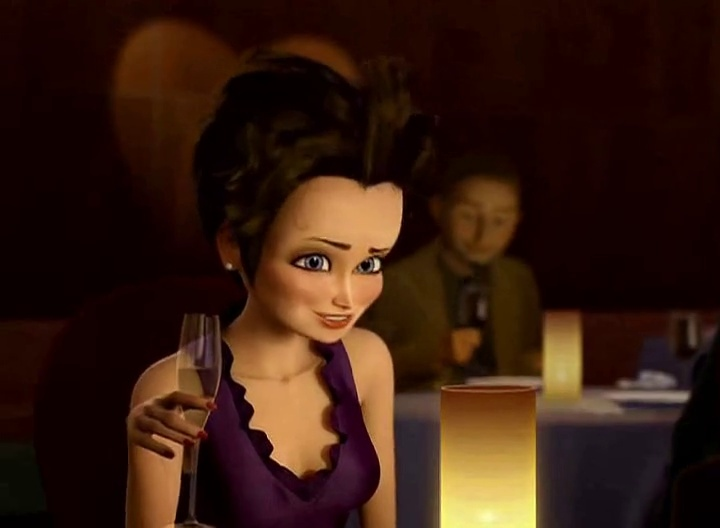

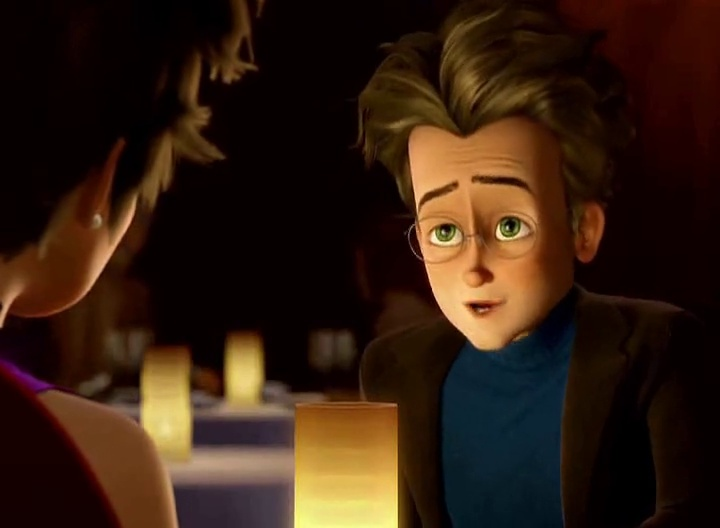

In [7]:
qry = \
[ 
    {
        "FindFrames": 
        {
            "frames": [25, 130],
            "constraints": 
            {
                "name": ["==", "megamind_clip"]
            }, 
            "format": "jpg"
        }
    }
]

response, blob = db.query(qry)

print(response)
print ("Number of images:", len(blob))
util.display_images(blob)    

#### FindFrames with Frame Id(s) and returns **Dense Array**

When we request for dense format, the returned blob consists of serialized pixel data, followed by height, width and channel of the array. Following show the way to unpack the returned blob. You find the displayed in odd color but this is expected as the blue and green channel are swapped in OpenCV Mat.

[{'FindFrames': {'returned': 1, 'status': 0}}]
Number of images: 2


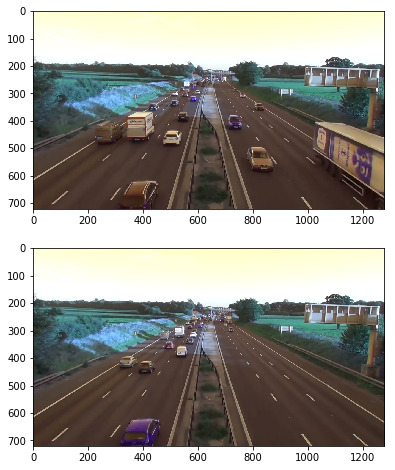

In [8]:
qry = \
[ 
    {
        "FindFrames": 
        {
            "frames": [76, 189],
            "constraints": 
            {
                "name": ["==", "f65sec"]
            }, 
            "format": "mat"
        }
    }
]

response, blob = db.query(qry)

print(response)
print ("Number of images:", len(blob))

fig, ax = plt.subplots(len(blob), figsize=(12,8))

for i, blb in enumerate(blob):
    height = unpack('I', blb[-12:-8])[0]
    width = unpack('I', blb[-8:-4])[0]
    channel = unpack('I', blb[-4:])[0]
    
    mat = np.array(list(iter_unpack('B', blb[:-12]))).reshape(height, width, channel)
    ax[i].imshow(mat)

#### FindFrames with **Interval** and returns **Compressed video**

Let's get the last 5 seconds of the f65sec video

In [9]:
qry = \
[ 
    {
        "FindFrames": 
        {
            "constraints": 
            {
                "name": ["==", "f65sec"]
            }, 
            "operations": 
            [
                {
                    "type": "interval",
                    "start": 1500,
                    "stop": 1625,
                    "step": 1
                }
            ],
            "format": "mp4"
        }
    }
]

response, blob = db.query(qry)

print(response)
print("MP4 Size:", len(blob[0])/1024, "KB")

vidpath='findframes_last_5sec.mp4'
with open(vidpath, 'wb+') as fd:
    fd.write(blob[0])

[{'FindFrames': {'returned': 1, 'status': 0}}]
MP4 Size: 599.240234375 KB


You can download *findframes_last_5sec.mp4* and play it.